In [25]:
import mlflow
from mlflow import MlflowClient
from pprint import pprint
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

Create an Experiment

In [27]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")
all_experiments = client.search_experiments()
print(all_experiments)


[<Experiment: artifact_location='mlflow-artifacts:/529349906327810342', creation_time=1724854034675, experiment_id='529349906327810342', last_update_time=1724854034675, lifecycle_stage='active', name='All_Patients', tags={'mlflow.note.content': 'Testing MLFlow using Diabetes Dataset. This '
                        'experiment concerns prediction of diabetes '
                        'progression for all patients indistinctively.',
 'patient_type': 'all',
 'project_name': 'diabetes-progression',
 'team': 'Matthieu'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1724854012148, experiment_id='0', last_update_time=1724854012148, lifecycle_stage='active', name='Default', tags={}>]


In [28]:
default_experiment = [
    {"name": experiment.name, "lifecycle_stage": experiment.lifecycle_stage}
    for experiment in all_experiments
    if experiment.name == "Default"
][0]

pprint(default_experiment)

{'lifecycle_stage': 'active', 'name': 'Default'}


In [29]:
dataset = load_diabetes()
X = dataset['data']
y = dataset['target']

In [30]:
X.shape

(442, 10)

In [32]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Testing MLFlow using Diabetes Dataset. "
    "This experiment concerns prediction of diabetes progression for all patients indistinctively."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "diabetes-progression",
    "patient_type": "all",
    "team": "Matthieu",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
all_patients_experiment = client.create_experiment(
    name="All_Patients_2", tags=experiment_tags
)

Search experiments based on tags

In [44]:
diabetes_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'diabetes-progression'"
)

print(vars(diabetes_experiment[0]))

{'_experiment_id': '351976444445137087', '_name': 'All_Patients_2', '_artifact_location': 'mlflow-artifacts:/351976444445137087', '_lifecycle_stage': 'active', '_tags': {'project_name': 'diabetes-progression', 'mlflow.note.content': 'Testing MLFlow using Diabetes Dataset. This experiment concerns prediction of diabetes progression for all patients indistinctively.', 'patient_type': 'all', 'team': 'Matthieu'}, '_creation_time': 1724870020178, '_last_update_time': 1724870020178}


Tracking training

In [54]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# Sets the current active experiment to the "Apple_Models" experiment and
# returns the Experiment metadata
all_patients_experiment = mlflow.set_experiment("All_Patients_2")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
# run_name = "test_1"

# Define an artifact path that the model will be saved to.
artifact_path = "All_Patients_3"


In [55]:
# # Split the data into features and target and drop irrelevant date field and target field
# X = data.drop(columns=["date", "demand"])
# y = data["demand"]

In [56]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state": 888,
}

# Train the RandomForestRegressor
rf = RandomForestRegressor(**params)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf.predict(X_val)

# Calculate error metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Assemble the metrics we're going to write into a collection
metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

# Initiate the MLflow run context
with mlflow.start_run() as run:
    # Log the parameters used for the model fit
    mlflow.log_params(params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    model_info = mlflow.sklearn.log_model(
        sk_model=rf, input_example=X_val, artifact_path=artifact_path
    )


/Users/matthieu/miniconda3/envs/mlflow-test/lib/python3.10/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/matthieu/miniconda3/envs/mlflow-test/lib/python3.10/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/28 20:46:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-sponge-635

In [59]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

In [61]:
predictions = loaded_model.predict(X)

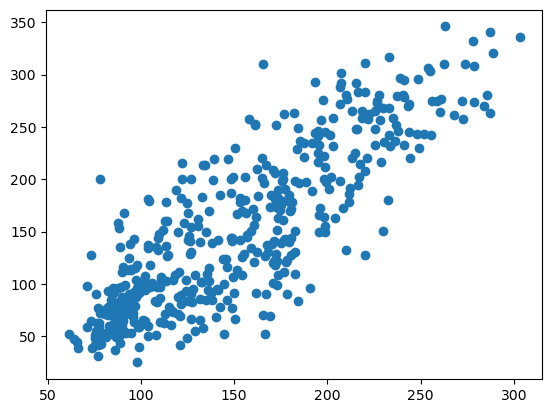

In [63]:
plt.scatter(predictions, y)